In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

tf.set_random_seed(1)
np.random.seed(1)

Using TensorFlow backend.


In [2]:
#Just for drawing the confusion matrix.
import itertools
def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#Scaling
df = pd.read_csv('creditcard.csv')
df = df.sample(frac=1).reset_index(drop=True)
               
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [4]:
# Spiit the Original Data into Original test & Original Train using Striatified for saving data structure.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

x = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
np.sum(y_train)

(227846, 30) (227846,) (56961, 30) (56961,)


394

[[56853    10]
 [   45    53]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.84      0.54      0.66        98

    accuracy                           1.00     56961
   macro avg       0.92      0.77      0.83     56961
weighted avg       1.00      1.00      1.00     56961

0.9990344270641316


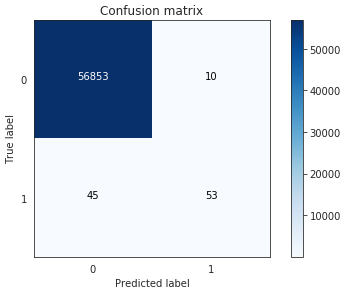

In [5]:
# Logisitic for originals
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)#GridSearchCV(model, parameter_grid)
grid_log_reg.fit(x_train, y_train)

log_reg = grid_log_reg.best_estimator_ #best C(Normalize Factor): 0.01
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

In [6]:
## UnderSampling
nm = NearMiss(sampling_strategy='majority')
x_train_u, y_train_u = nm.fit_sample(x_train, y_train)
x_train_u.shape, y_train_u.shape

((788, 30), (788,))

[[38757 18106]
 [    6    92]]
              precision    recall  f1-score   support

           0       1.00      0.68      0.81     56863
           1       0.01      0.94      0.01        98

    accuracy                           0.68     56961
   macro avg       0.50      0.81      0.41     56961
weighted avg       1.00      0.68      0.81     56961

0.6820280542827548


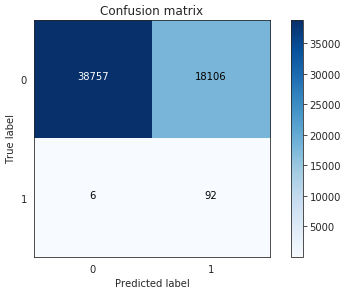

In [7]:
# Logisitic for the undersampling method.
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [1e-3, 0.01, 0.1, 1, 10, 100, 1e+3]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)#GridSearchCV(model, parameter_grid)
grid_log_reg.fit(x_train_u, y_train_u)

log_reg = grid_log_reg.best_estimator_ #best C(Normalize Factor): 1
log_reg.fit(x_train_u, y_train_u)
y_pred = log_reg.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()


In [8]:
## OverSampling
ss = SVMSMOTE(sampling_strategy='minority')
x_train_o, y_train_o = ss.fit_sample(x_train, y_train)
x_train_o.shape, y_train_o.shape

((454904, 30), (454904,))

[[56392   471]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.16      0.90      0.27        98

    accuracy                           0.99     56961
   macro avg       0.58      0.94      0.63     56961
weighted avg       1.00      0.99      0.99     56961

0.9915556257790418


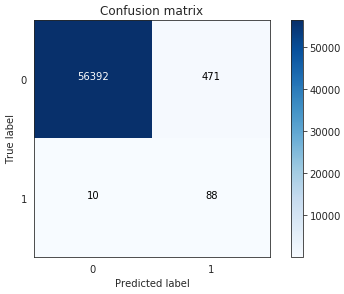

In [9]:
# Logisitic for oversampling for the oversampling method.
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [1e-3, 0.01, 0.1, 1, 10, 100, 1e+3]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)#GridSearchCV(model, parameter_grid)
grid_log_reg.fit(x_train_o, y_train_o)

log_reg = grid_log_reg.best_estimator_ #best C(Normalize Factor): 1
log_reg.fit(x_train_o, y_train_o)
y_pred = log_reg.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

with sns.axes_style("white"):
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

In [10]:
##Drawings for the presentation
# Under Sampling
col = df.columns
df1 = pd.DataFrame(x_train_u.reshape(788,30), columns=col[:30])
df2 = pd.DataFrame(y_train_u.reshape(788,1), columns=col[30:])
df_u = pd.concat([df1,df2], axis=1)

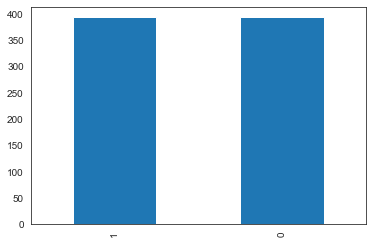

1    394
0    394
Name: Class, dtype: int64
1    0.5
0    0.5
Name: Class, dtype: float64


In [11]:
with sns.axes_style("white"):
    df_u.Class.value_counts().plot(kind='bar')
    plt.show()
print(df_u['Class'].value_counts())
print(df_u['Class'].value_counts()/len(df_u['Class']))

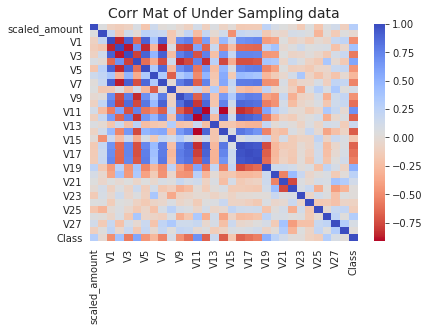

In [12]:
with sns.axes_style("white"):
    sub_sample_corr = df_u.corr()
    sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20})
    plt.title('Corr Mat of Under Sampling data', fontsize=14)
plt.show()

In [13]:
# Under Sampling
df1 = pd.DataFrame(x_train_o.reshape(454904,30), columns=col[:30])
df2 = pd.DataFrame(y_train_o.reshape(454904,1), columns=col[30:])
df_o = pd.concat([df1,df2], axis=1)

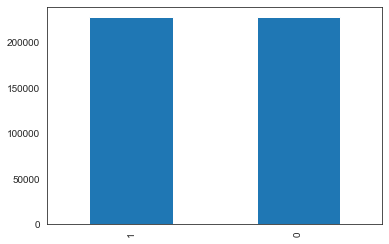

1    227452
0    227452
Name: Class, dtype: int64
1    0.5
0    0.5
Name: Class, dtype: float64


In [14]:
with sns.axes_style("white"):
    df_o.Class.value_counts().plot(kind='bar')
    plt.show()
print(df_o['Class'].value_counts())
print(df_o['Class'].value_counts()/len(df_o['Class']))

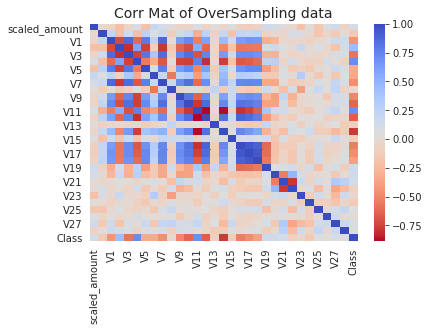

In [15]:
with sns.axes_style("white"):
    sub_sample_corr_2 = df_o.corr()
    sns.heatmap(sub_sample_corr_2, cmap='coolwarm_r', annot_kws={'size':20})
    plt.title('Corr Mat of OverSampling data', fontsize=14)
plt.show()